## Background

---

This is the first of a series of two notebooks, where we forecast sales for a retailers with 45 stores, each contains several departments, in multiple regions. We also want to understand the extent to which external factors, including holidays and promotions, affect sales in different departments, stores, and regions. In this notebook, we are going to focus on the exploration and manipulation of our data, whereas the next one would be centered around modeling itself. Understanding the data is important for analytics, and we recommend you to read both notebooks in order to gain a better grasp of analytics for big and messy data. The three datasets that we are using are already included (see the "Data" folder) in the repository where this Jupyter notebook is located, but you can also find them on [this Kaggle page](https://www.kaggle.com/manjeetsingh/retaildataset?select=sales+data-set.csv). 

One of the most commonly used time series forecasting model are ARIMA models, which is what we are going to use in this notebook. However, there are also other models that you could use, such as ETS Models. At the same time, since we want to understand the relationships between sales and several other variables, including mark downs, holidays, and potentially weather (temperature), it would be benefitial for us to build a Simple or Multiple Linear Regression Model first, with sales as the response variable. Then we can build time series models to forecast the explanatory variables, such as temperature, and plug in the time-series predicted explantory variables into the SLR/MLR models to generate further forecasts for the response variable,sales. Models generated in this manner might be less accurate as we are going through multiple steps, each adding more risks for errors; however, time series models combined with explanatory models are more interpretable and provide you with more managerial insights that could help you make recommendations and decisions. Let's go ahead and import the libraries we need and load our data:

In [1]:
# basic tools for data analysis and visualization in Python
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

# ipywidgets are used to make interactive contents in Jupyter notebooks
from ipywidgets import interact

In [2]:
df_sales = pd.read_csv('Data/sales.csv')
df_features = pd.read_csv('Data/features.csv')
df_stores = pd.read_csv('Data/stores.csv')

# converting the date column (initally stored as strings) to dates
df_sales['Date'] = pd.to_datetime(df_sales['Date'], format='%d/%m/%Y')
df_features['Date'] = pd.to_datetime(df_features['Date'], format='%d/%m/%Y')

df_sales['Store'] = df_sales['Store'].astype('category')
df_sales['Dept'] = df_sales['Dept'].astype('category')
df_features['Store'] = df_features['Store'].astype('category')
df_stores['Store'] = df_stores['Store'].astype('category')
df_stores['Type'] = df_stores['Type'].astype('category')

# Information on the SettingWithCopywarning that might occur: 
# https://www.dataquest.io/blog/settingwithcopywarning/

## Exploratory Data Analysis

---

Before we build a model, it is always a good idea to take a look at the data itself. Some questions that you might ask when exploring your data are:

- What information is recorded (what do different columns contain)?
- How frequently (since we are working with time series data) is the data recorded?
- How many missing values are there in each column? 
- What are the distributions of the different columns? 
- Are any columns highly correlated to one another?

After exploration, if there are lots of missing values or if the distribution of a column is highly left/right skewed, which could potentially affect the accruacy of your models, you would want to think about replacing or transforming them before you build, compare, and select your models.

In [3]:
def sales_viz(store_num, dept_num):
    fig, axes = plt.subplots(1,2, figsize=(10,3), dpi=100)
    sales_temp = df_sales[(df_sales.Store==store_num) & (df_sales.Dept==dept_num)][['Date', 'Weekly_Sales']]
    ts_sales_temp = sales_temp.set_index('Date')
    ts_sales_temp.plot(ax=axes[0], legend=False)
    ts_sales_temp.hist(ax=axes[1], bins=100)
    return (display(ts_sales_temp.describe().transpose().round(2)), plt.show())

interact(sales_viz, store_num={n:n for n in range(1,46)}, dept_num={n:n for n in range(1,100)})

interactive(children=(Dropdown(description='store_num', options={1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: …

<function __main__.sales_viz(store_num, dept_num)>

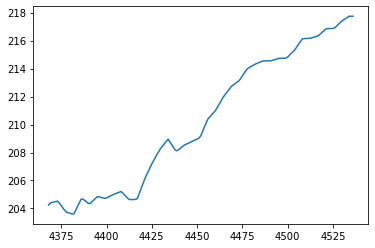

In [14]:
df_features[df_features['Store']==25]['CPI'].plot()

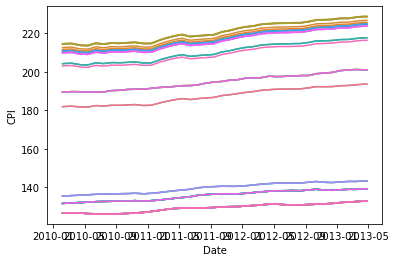

In [16]:
sns.lineplot(x="Date", y="CPI", hue="Store", data=df_features, legend=False)

### Inspection

#### `Sales`

First, let's take a look at the `sales` dataframe:

In [4]:
print(df_sales.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 421570 entries, 0 to 421569
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  category      
 1   Dept          421570 non-null  category      
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
dtypes: bool(1), category(2), datetime64[ns](1), float64(1)
memory usage: 7.6 MB
None


count      mean       std      min      25%      50%  \
Weekly_Sales  421570.0  15981.26  22711.18 -4988.94  2079.65  7612.03   

                   75%        max  
Weekly_Sales  20205.85  693099.36

CAUTION: 0.30% of the `Weekly_Sales` column is negative.


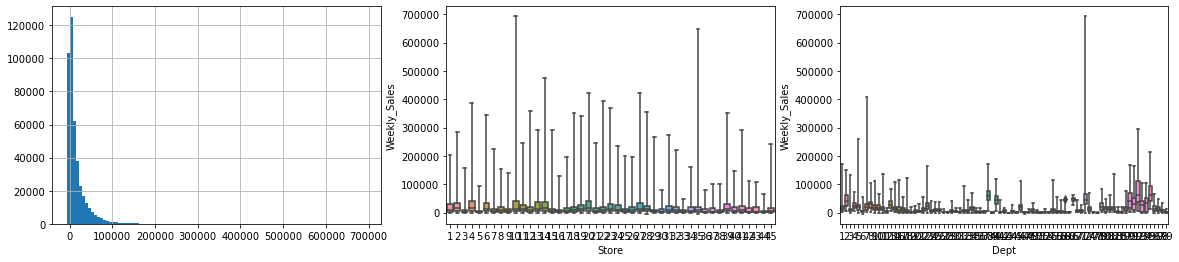

In [41]:
display(df_sales.describe().transpose().round(2))

print("CAUTION: {:.2%} of the `Weekly_Sales` column is negative."
      .format(len([n for n in df_sales['Weekly_Sales'] if n < 0])/
              len(df_sales['Weekly_Sales'])))

fig, axes = plt.subplots(1,3, figsize=(20,4))
df_sales['Weekly_Sales'].hist(bins=100, ax=axes[0])
sns.boxplot(x='Store', y='Weekly_Sales', whis=100, data=df_sales, ax=axes[1])
sns.boxplot(x='Dept', y='Weekly_Sales', whis=100, data=df_sales, ax=axes[2])
plt.show()

count unique                  top    freq      first       last
Store      421570     45                   13   10474        NaT        NaT
Dept       421570     81                    1    6435        NaT        NaT
Date       421570    143  2011-12-23 00:00:00    3027 2010-02-05 2012-10-26
IsHoliday  421570      2                False  391909        NaT        NaT

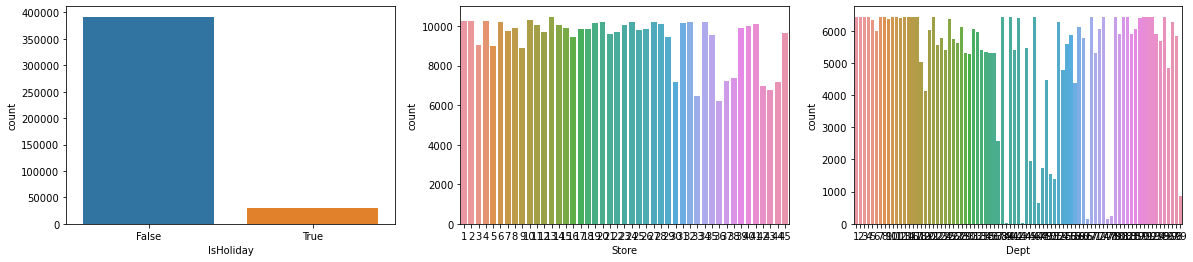

In [40]:
display(df_sales.drop('Weekly_Sales', axis=1).describe().transpose())
fig, axes = plt.subplots(1,3, figsize=(20,4))
sns.countplot(x='IsHoliday', data=df_sales, ax=axes[0])
sns.countplot(x='Store', data=df_sales, ax=axes[1])
sns.countplot(x='Dept', data=df_sales, ax=axes[2])
plt.show()

99.68% of the `Weekly_Sales` column is positive. We could probably just drop the negative values so that we could take logarithms of the rest in order to make our data less skewed.

Now that we have taken a look at the aggregated data, we want to look at the sales of each store and department on an individual level. However, it is not the most efficient to print or plot the subsets one by one. Luckily, the `interact()` function from the [ipywidgets](https://ipywidgets.readthedocs.io/en/latest/) package allow us to create an interactive "dashboard" in Jupyter notebooks:

We can see that:

1. There are 143 unique dates (421,570 records in total) from 2010-02-05 to 2012-10-26 in the `sales` dataframe. We should keep in mind at this point that, on each day, sales across multiple stores with several departments are recorded, even though we do not know if all stores or departments are open on each of the 143 days. 
2. There is no missing values in any column of this dataframe, which is good.
3. However, we should notice that the `weekly sales` column is extremely right skewed, with a mean of \\$15,981, but a 50th percentile (mostly the same as the median) of only \\$7,612. The range of the column is also fairly large, from -\\$4,989 to \\$693,099.
4. 391,909 records out of 421,570 are not holidays (or about 7% of the records *are* holidays), which could potentially explain why the `weekly sales` records are extremely right skewed (*maybe* most of the sales happen on holidays).

#### `Features`

Now let's move onto the `features` dataframe:

In [7]:
print(df_features.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Store         8190 non-null   category      
 1   Date          8190 non-null   datetime64[ns]
 2   Temperature   8190 non-null   float64       
 3   Fuel_Price    8190 non-null   float64       
 4   MarkDown1     4032 non-null   float64       
 5   MarkDown2     2921 non-null   float64       
 6   MarkDown3     3613 non-null   float64       
 7   MarkDown4     3464 non-null   float64       
 8   MarkDown5     4050 non-null   float64       
 9   CPI           7605 non-null   float64       
 10  Unemployment  7605 non-null   float64       
 11  IsHoliday     8190 non-null   bool          
dtypes: bool(1), category(1), datetime64[ns](1), float64(9)
memory usage: 657.6 KB
None


In [8]:
display(df_features[df_features['CPI'].isnull()])
display(df_features[df_features['Unemployment'].isnull()])

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
169      1 2013-05-03        66.66       3.386    2298.63       2.00   
170      1 2013-05-10        63.90       3.392    4624.61      83.88   
171      1 2013-05-17        69.53       3.454   16170.50      92.00   
172      1 2013-05-24        77.19       3.494    7959.89     178.00   
173      1 2013-05-31        78.02       3.466    2369.77     142.45   
...    ...        ...          ...         ...        ...        ...   
8185    45 2013-06-28        76.05       3.639    4842.29     975.03   
8186    45 2013-07-05        77.50       3.614    9090.48    2268.58   
8187    45 2013-07-12        79.37       3.614    3789.94    1827.31   
8188    45 2013-07-19        82.84       3.737    2961.49    1047.07   
8189    45 2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday  
169      129.90      55.46    1301.04  NaN           NaN      False  
170       42.38    1618.31    8144.90  NaN           NaN      False  
171        8.32    4127.24    6206.97  NaN           NaN      False  
172     1621.47    3152.57    2938.70  NaN           NaN      False  
173      475.35      45.55    2056.84  NaN           NaN      False  
...         ...        ...        ...  ...           ...        ...  
8185       3.00    2449.97    3169.69  NaN           NaN      False  
8186     582.74    5797.47    1514.93  NaN           NaN      False  
8187      85.72     744.84    2150.36  NaN           NaN      False  
8188     204.19     363.00    1059.46  NaN           NaN      False  
8189       2.06      10.88    1864.57  NaN           NaN      False  

[585 rows x 12 columns]

Store       Date  Temperature  Fuel_Price  MarkDown1  MarkDown2  \
169      1 2013-05-03        66.66       3.386    2298.63       2.00   
170      1 2013-05-10        63.90       3.392    4624.61      83.88   
171      1 2013-05-17        69.53       3.454   16170.50      92.00   
172      1 2013-05-24        77.19       3.494    7959.89     178.00   
173      1 2013-05-31        78.02       3.466    2369.77     142.45   
...    ...        ...          ...         ...        ...        ...   
8185    45 2013-06-28        76.05       3.639    4842.29     975.03   
8186    45 2013-07-05        77.50       3.614    9090.48    2268.58   
8187    45 2013-07-12        79.37       3.614    3789.94    1827.31   
8188    45 2013-07-19        82.84       3.737    2961.49    1047.07   
8189    45 2013-07-26        76.06       3.804     212.02     851.73   

      MarkDown3  MarkDown4  MarkDown5  CPI  Unemployment  IsHoliday  
169      129.90      55.46    1301.04  NaN           NaN      False  
170       42.38    1618.31    8144.90  NaN           NaN      False  
171        8.32    4127.24    6206.97  NaN           NaN      False  
172     1621.47    3152.57    2938.70  NaN           NaN      False  
173      475.35      45.55    2056.84  NaN           NaN      False  
...         ...        ...        ...  ...           ...        ...  
8185       3.00    2449.97    3169.69  NaN           NaN      False  
8186     582.74    5797.47    1514.93  NaN           NaN      False  
8187      85.72     744.84    2150.36  NaN           NaN      False  
8188     204.19     363.00    1059.46  NaN           NaN      False  
8189       2.06      10.88    1864.57  NaN           NaN      False  

[585 rows x 12 columns]

Temperature  Fuel_Price  MarkDown1  MarkDown2  MarkDown3  MarkDown4  \
count      8190.00     8190.00    4032.00    2921.00    3613.00    3464.00   
mean         59.36        3.41    7032.37    3384.18    1760.10    3292.94   
std          18.68        0.43    9262.75    8793.58   11276.46    6792.33   
min          -7.29        2.47   -2781.45    -265.76    -179.26       0.22   
25%          45.90        3.04    1577.53      68.88       6.60     304.69   
50%          60.71        3.51    4743.58     364.57      36.26    1176.42   
75%          73.88        3.74    8923.31    2153.35     163.15    3310.01   
max         101.95        4.47  103184.98  104519.54  149483.31   67474.85   

       MarkDown5      CPI  Unemployment  
count    4050.00  7605.00       7605.00  
mean     4132.22   172.46          7.83  
std     13086.69    39.74          1.88  
min      -185.17   126.06          3.68  
25%      1440.83   132.36          6.63  
50%      2727.14   182.76          7.81  
75%      4832.56   213.93          8.57  
max    771448.10   228.98         14.31

CAUTION: 0.10% of MarkDown1 (non-null) is negative.
CAUTION: 0.86% of MarkDown2 (non-null) is negative.
CAUTION: 0.36% of MarkDown3 (non-null) is negative.
CAUTION: 0.00% of MarkDown4 (non-null) is negative.
CAUTION: 0.05% of MarkDown5 (non-null) is negative.


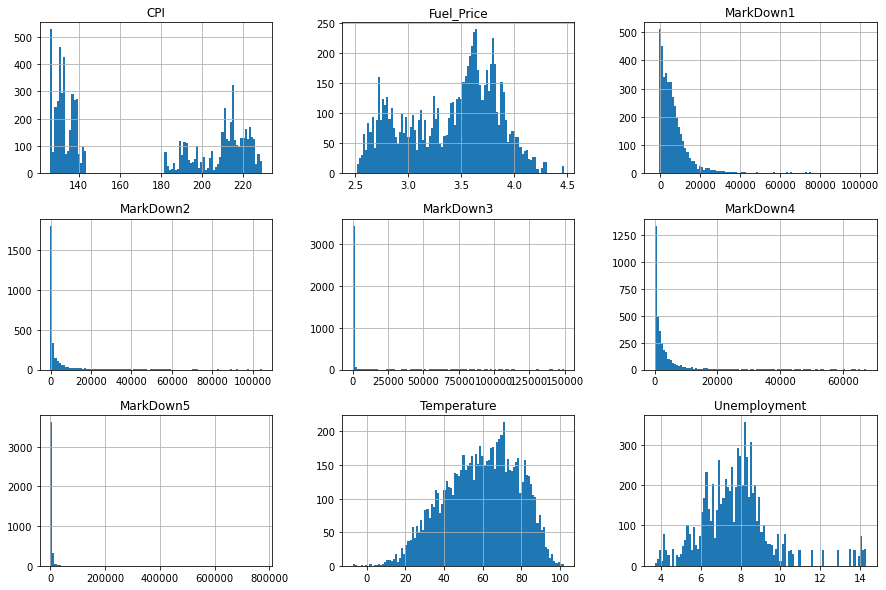

In [9]:
display(df_features.describe().round(2))

for i in range(5):
    print('CAUTION: {:.2%} of MarkDown{} (non-null) is negative.'
          .format(len([n for n in df_features['MarkDown'+str(i+1)] if n < 0])/
                  len(df_features['MarkDown'+str(i+1)].dropna()), i+1))

df_features.drop(['Store', 'Date', 'IsHoliday'], axis=1).hist(figsize=(15,10), bins=100)
plt.show()

count unique                  top  freq      first       last
Store      8190     45                   45   182        NaT        NaT
Date       8190    182  2011-07-15 00:00:00    45 2010-02-05 2013-07-26
IsHoliday  8190      2                False  7605        NaT        NaT

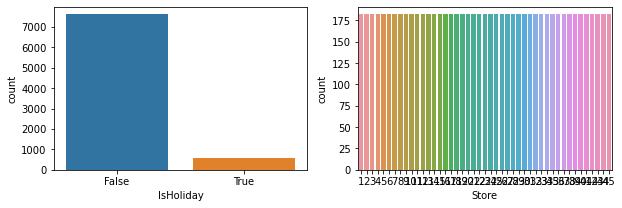

In [10]:
display(df_features[['Store', 'Date', 'IsHoliday']].describe().transpose())

fig, axes = plt.subplots(1,2, figsize=(10,3))
sns.countplot(x='IsHoliday', data=df_features, ax=axes[0])
sns.countplot(x='Store', data=df_features, ax=axes[1])
plt.show()

Right away, we can see that:

1. Compared to the `sales` dataframe, there are less records (8190) in the `features` dataframe. It makes sense because this dataframe is only detailed to store level and not department; for example, different departments in the same store *probably* experience the same weather on the same day. 
2. However, with only store level data, we might find it harder to model the effect of markdowns across different departments within the same store. 
3. The are 182 unique dates from 2010-02-05 to 2013-07-26, which is a wider range of record than the `sales` dataframe.
4. From the first 10 rows, we can see that the dates do match up; however, it wouldn't hurt to check the proportion of matching records (by date and store) especially if we are thinking about merging together the two dataframes
5. The 5 mark down columns contain 'anonymous data related to promotional mark downs' as per Kaggle, and we might want to further inspect these columns (e.g. whether two mark downs occured at any point for the same store); at the same time, these 5 columns are also extremely right skewed
6. Again, approximately 7% of the 8190 `features` records are holidays, which is consistent with the `sales` dataframe

#### `Stores`

Last but not least, let's take a look at the `stores` dataframe:

In [174]:
display(df_stores.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Store   45 non-null     int64 
 1   Type    45 non-null     object
 2   Size    45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


None

count unique  top freq    mean      std    min    25%     50%     75%  \
Type    45      3    A   22     NaN      NaN    NaN    NaN     NaN     NaN   
Size    45    NaN  NaN  NaN  130288  63825.3  34875  70713  126512  202307   

         max  
Type     NaN  
Size  219622

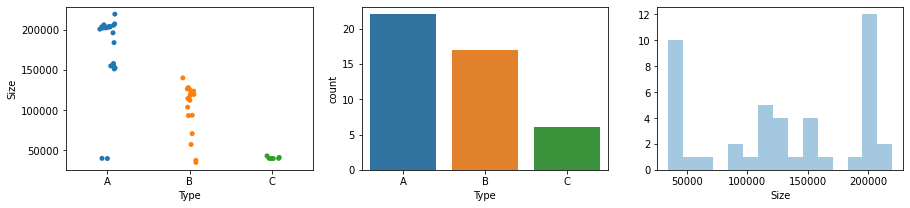

In [176]:
display(pd.DataFrame(df_stores.drop('Store', axis=1).describe(include='all')).transpose().round(2))

fig, axes = plt.subplots(1,3, figsize=(15,3))
sns.stripplot(x='Type', y='Size', data=df_stores, ax=axes[0])
sns.countplot(x='Type', data=df_stores, ax=axes[1])
sns.distplot(df_stores['Size'], bins=15, kde=False, ax=axes[2])
plt.show()

The `stores` dataframe appear to be smaller and simper. We can see that:

1. Almost half of the stores are type A stores; we might want to explore later whether there is any correlation between `store type` and other variables in the three dataframes
2. `Sizes` of the stores are not extremely skewed, with its mean close to its 50th percentile. However, we might want to check if they are light or heavy tailed.

### Aggregation

At a glance (by randomly inspecting different combinations), seasonalities and trends vary across stores and departments. Some stores/deparments have consistant sales throughout time, while some others see huge spikes either in the middle or at the end of each year. There are also increasing or decreasing trends in certain stores/departments. 

Even though is nice to be able to see detailed sales performance for each individual department in every store, we also want to inspect whether there are shared patterns in our sales data. Thus, let's aggregate the data a little bit so that we could visualize and compare sales across different stores for the same department and then across different departments in the same store.

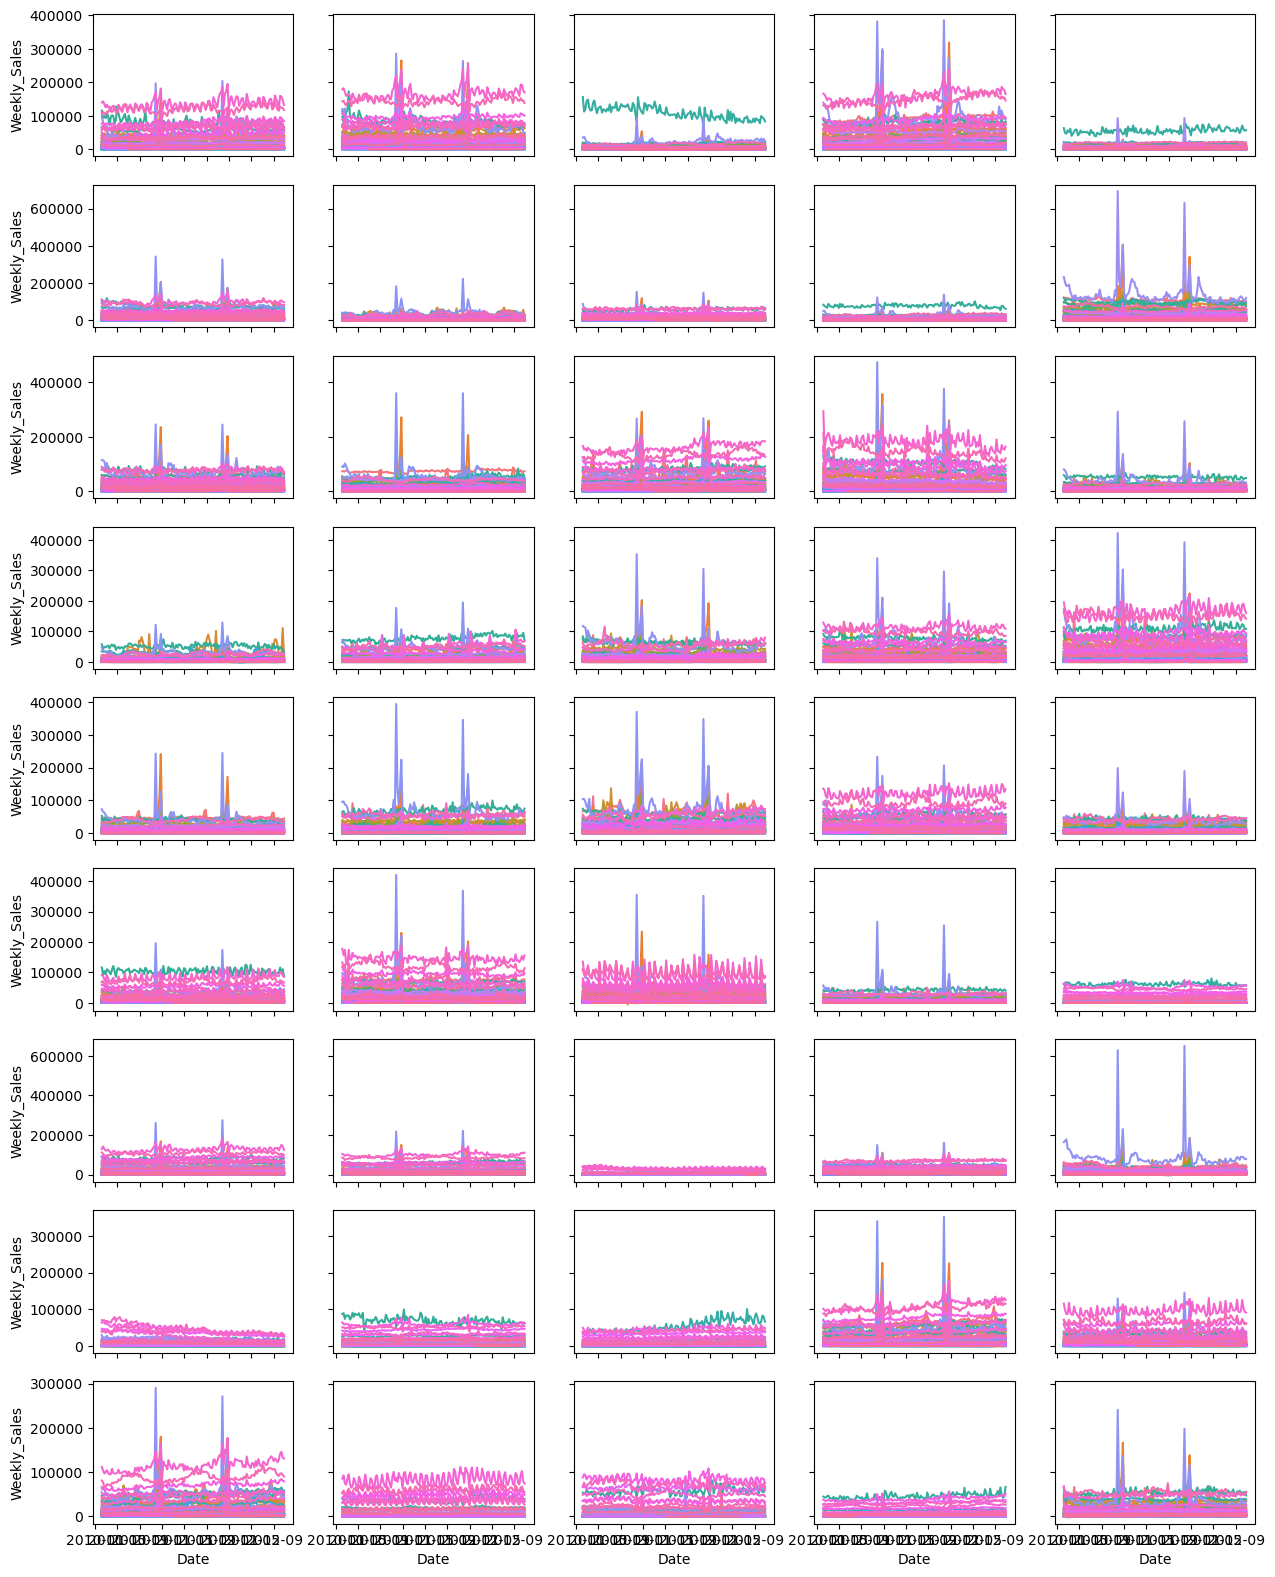

In [27]:
fig, ax = plt.subplots(9, 5, sharex='col', sharey='row', figsize=(15, 20), dpi=100)
store_num = pd.Series(range(1,46), dtype='category')
store_index = 0
for i in range(9):
    for j in range(5):
        sales_temp = df_sales[df_sales.Store==store_num[store_index]][['Date', 'Dept', 'Weekly_Sales']]
        sales_temp['Dept'] = sales_temp['Dept'].astype('category')
        sns.lineplot(x='Date', y='Weekly_Sales', hue='Dept', data=sales_temp, legend=False, ax=ax[i,j])
        store_index += 1

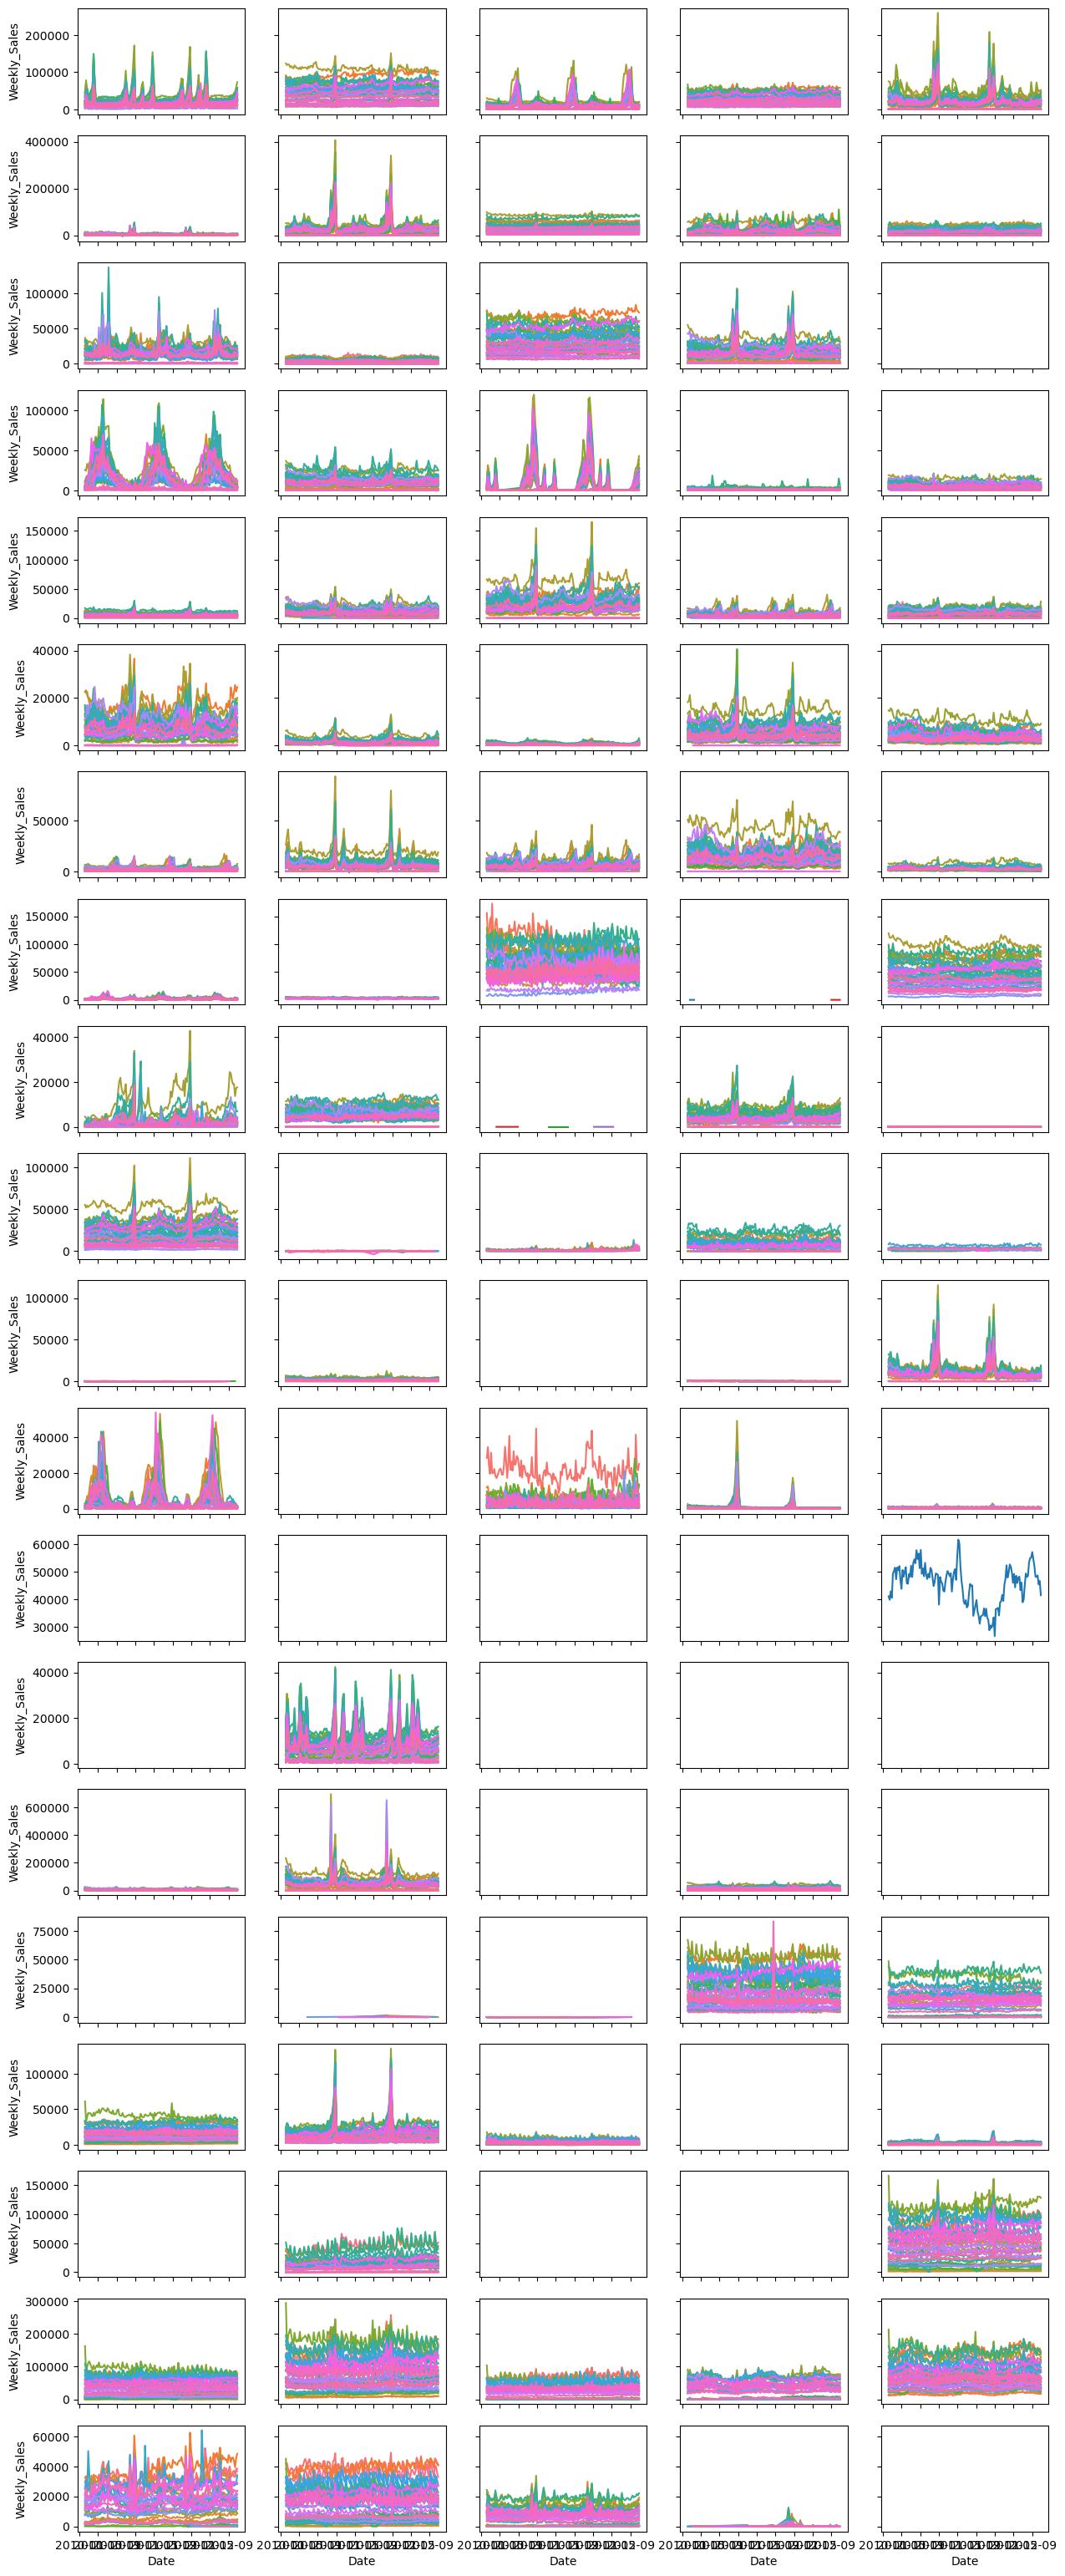

In [29]:
fig, ax = plt.subplots(20, 5, sharex='col', sharey='row', figsize=(15, 40), dpi=100)
dept_num = pd.Series(range(1,101), dtype='category')
dept_index = 0
for i in range(20):
    for j in range(5):
        sales_temp = df_sales[df_sales.Dept==dept_num[dept_index]][['Date', 'Store', 'Weekly_Sales']]
        sales_temp['Store'] = sales_temp['Store'].astype('category')
        sns.lineplot(x='Date', y='Weekly_Sales', hue='Store', data=sales_temp, legend=False, ax=ax[i,j])
        dept_index += 1

#### Merging

In [93]:
df_all = df_sales.merge(df_features, 
                        on=['Store', 'Date', 'IsHoliday'], 
                        how='left').merge(df_stores, 
                                          on='Store', 
                                          how='left')

print(df_all.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Store         421570 non-null  category      
 1   Dept          421570 non-null  category      
 2   Date          421570 non-null  datetime64[ns]
 3   Weekly_Sales  421570 non-null  float64       
 4   IsHoliday     421570 non-null  bool          
 5   Temperature   421570 non-null  float64       
 6   Fuel_Price    421570 non-null  float64       
 7   MarkDown1     150681 non-null  float64       
 8   MarkDown2     111248 non-null  float64       
 9   MarkDown3     137091 non-null  float64       
 10  MarkDown4     134967 non-null  float64       
 11  MarkDown5     151432 non-null  float64       
 12  CPI           421570 non-null  float64       
 13  Unemployment  421570 non-null  float64       
 14  Type          421570 non-null  category      
 15  Size          421

### Manipulation

#### Adjustment

In [104]:
mon_val = ['Weekly_Sales', 'Fuel_Price', 'MarkDown1', 'MarkDown2', 'MarkDown3', 'MarkDown4', 'MarkDown5']

df_adj = pd.concat([df_all.drop(mon_val, axis=1), 
                    (df_all[mon_val]*100).div(df_all.CPI, axis=0).add_prefix('AdjCPI_')], axis=1)

count         mean           std          min  \
AdjCPI_Weekly_Sales  421570.0  9908.548942  14602.240095 -3950.722934   
AdjCPI_MarkDown1     150681.0  4430.042457   5348.301090     0.206549   
AdjCPI_MarkDown2     111248.0  2059.609593   6003.485424  -192.610230   
AdjCPI_MarkDown3     137091.0   899.232310   6284.294887   -22.232464   
AdjCPI_MarkDown4     134967.0  2083.455218   4089.637783     0.167800   
AdjCPI_MarkDown5     151432.0  2747.854633   3245.911013    60.910013   

                             25%          50%           75%            max  
AdjCPI_Weekly_Sales  1195.198183  4512.777475  12421.081272  547172.473684  
AdjCPI_MarkDown1     1222.675566  3045.650515   5572.308352   62862.823404  
AdjCPI_MarkDown2       24.452601   110.381028   1120.970072   80355.739592  
AdjCPI_MarkDown3        2.904313    14.296407     64.518748  109083.900971  
AdjCPI_MarkDown4      288.936331   856.134875   2034.683587   47849.008580  
AdjCPI_MarkDown5     1098.292765  1949.324313   3324.396470   49200.118284

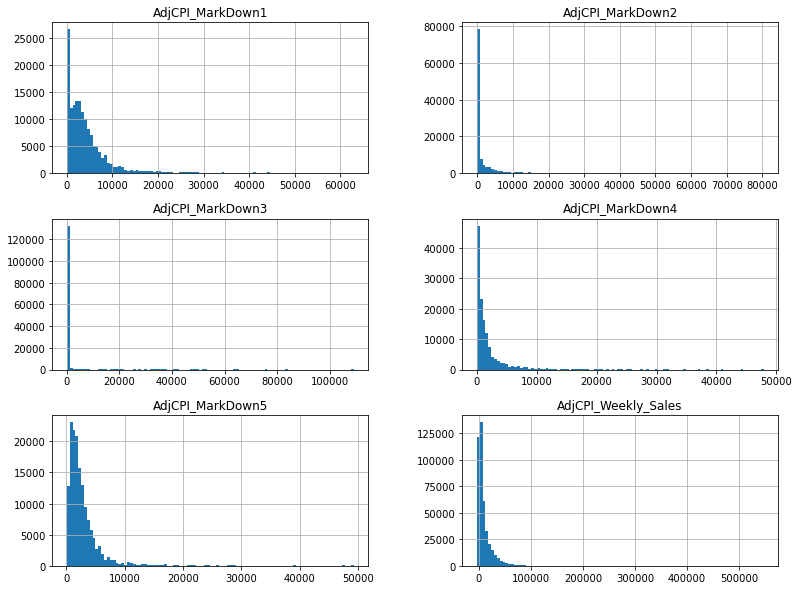

In [105]:
adj_val = ['AdjCPI_' + s for s in mon_val if s != 'Fuel_Price']

display(df_adj[adj_val].describe().transpose())

df_adj[adj_val].hist(bins=100, figsize=(13,10))
plt.show()

#### Remove Negative Values

In [106]:
df_pos = df_adj[((df_adj[adj_val]>0)|(df_adj[adj_val].isnull())).all(1)]

print(df_adj.shape)
print(df_pos.shape)

(421570, 16)
(418380, 16)


#### Transformation

In [120]:
df_trans = pd.concat([df_pos.drop(adj_val, axis=1), 
                     df_pos[adj_val].apply(lambda x: np.log(x)).add_prefix('TransLog_')], axis=1)
df_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418380 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Store                         418380 non-null  category      
 1   Dept                          418380 non-null  category      
 2   Date                          418380 non-null  datetime64[ns]
 3   IsHoliday                     418380 non-null  bool          
 4   Temperature                   418380 non-null  float64       
 5   CPI                           418380 non-null  float64       
 6   Unemployment                  418380 non-null  float64       
 7   Type                          418380 non-null  category      
 8   Size                          418380 non-null  int64         
 9   AdjCPI_Fuel_Price             418380 non-null  float64       
 10  TransLog_AdjCPI_Weekly_Sales  418380 non-null  float64       
 11  TransLog_AdjC

count      mean       std       min  \
TransLog_AdjCPI_Weekly_Sales  418380.0  8.009177  2.065827 -5.425113   
TransLog_AdjCPI_MarkDown1     148395.0  7.635139  1.603340 -1.577218   
TransLog_AdjCPI_MarkDown2     109186.0  4.965551  2.688230 -4.702690   
TransLog_AdjCPI_MarkDown3     134955.0  2.712321  2.410671 -5.410087   
TransLog_AdjCPI_MarkDown4     132732.0  6.496274  1.815088 -1.784981   
TransLog_AdjCPI_MarkDown5     149097.0  7.533416  0.884697  4.109398   

                                   25%       50%       75%        max  
TransLog_AdjCPI_Weekly_Sales  7.104933  8.422070  9.430193  13.212519  
TransLog_AdjCPI_MarkDown1     7.099678  8.020444  8.626376  11.048710  
TransLog_AdjCPI_MarkDown2     3.264481  4.749675  7.072172  11.294219  
TransLog_AdjCPI_MarkDown3     1.078231  2.672555  4.168216  11.599873  
TransLog_AdjCPI_MarkDown4     5.666128  6.748512  7.606688  10.775806  
TransLog_AdjCPI_MarkDown5     7.003998  7.575858  8.109043  10.803651

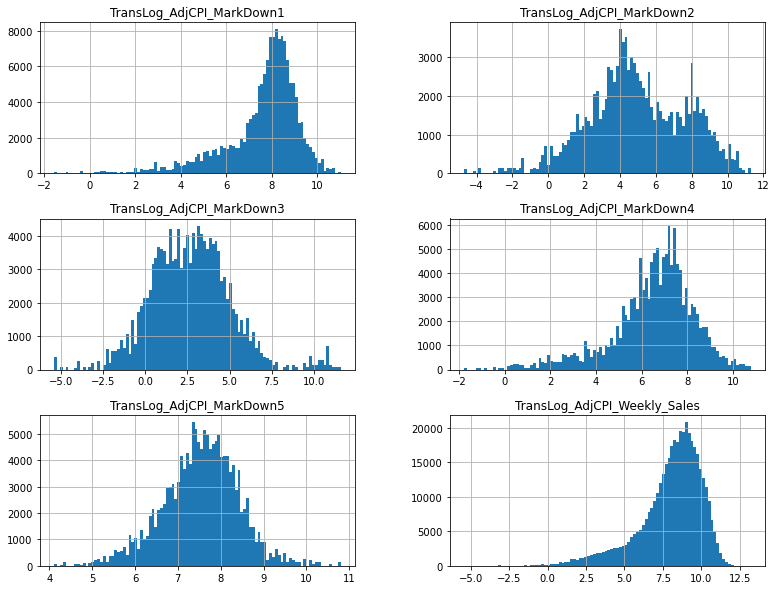

In [121]:
trans_val = ['TransLog_' + s for s in adj_val]

display(df_trans[trans_val].describe().transpose())

df_trans[trans_val].hist(bins=100, figsize=(13,10))
plt.show()

#### Replace Missing Values

In [126]:
df_full = pd.concat([df_trans.drop(trans_val, axis=1), df_trans[trans_val].fillna(0.0)], axis=1)
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 418380 entries, 0 to 421569
Data columns (total 16 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Store                         418380 non-null  category      
 1   Dept                          418380 non-null  category      
 2   Date                          418380 non-null  datetime64[ns]
 3   IsHoliday                     418380 non-null  bool          
 4   Temperature                   418380 non-null  float64       
 5   CPI                           418380 non-null  float64       
 6   Unemployment                  418380 non-null  float64       
 7   Type                          418380 non-null  category      
 8   Size                          418380 non-null  int64         
 9   AdjCPI_Fuel_Price             418380 non-null  float64       
 10  TransLog_AdjCPI_Weekly_Sales  418380 non-null  float64       
 11  TransLog_AdjC

C:\Users\Charlie\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Charlie\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)
C:\Users\Charlie\Anaconda3\lib\site-packages\seaborn\distributions.py:369: UserWarning: Default bandwidth for data is 0; skipping density estimation.
  warnings.warn(msg, UserWarning)


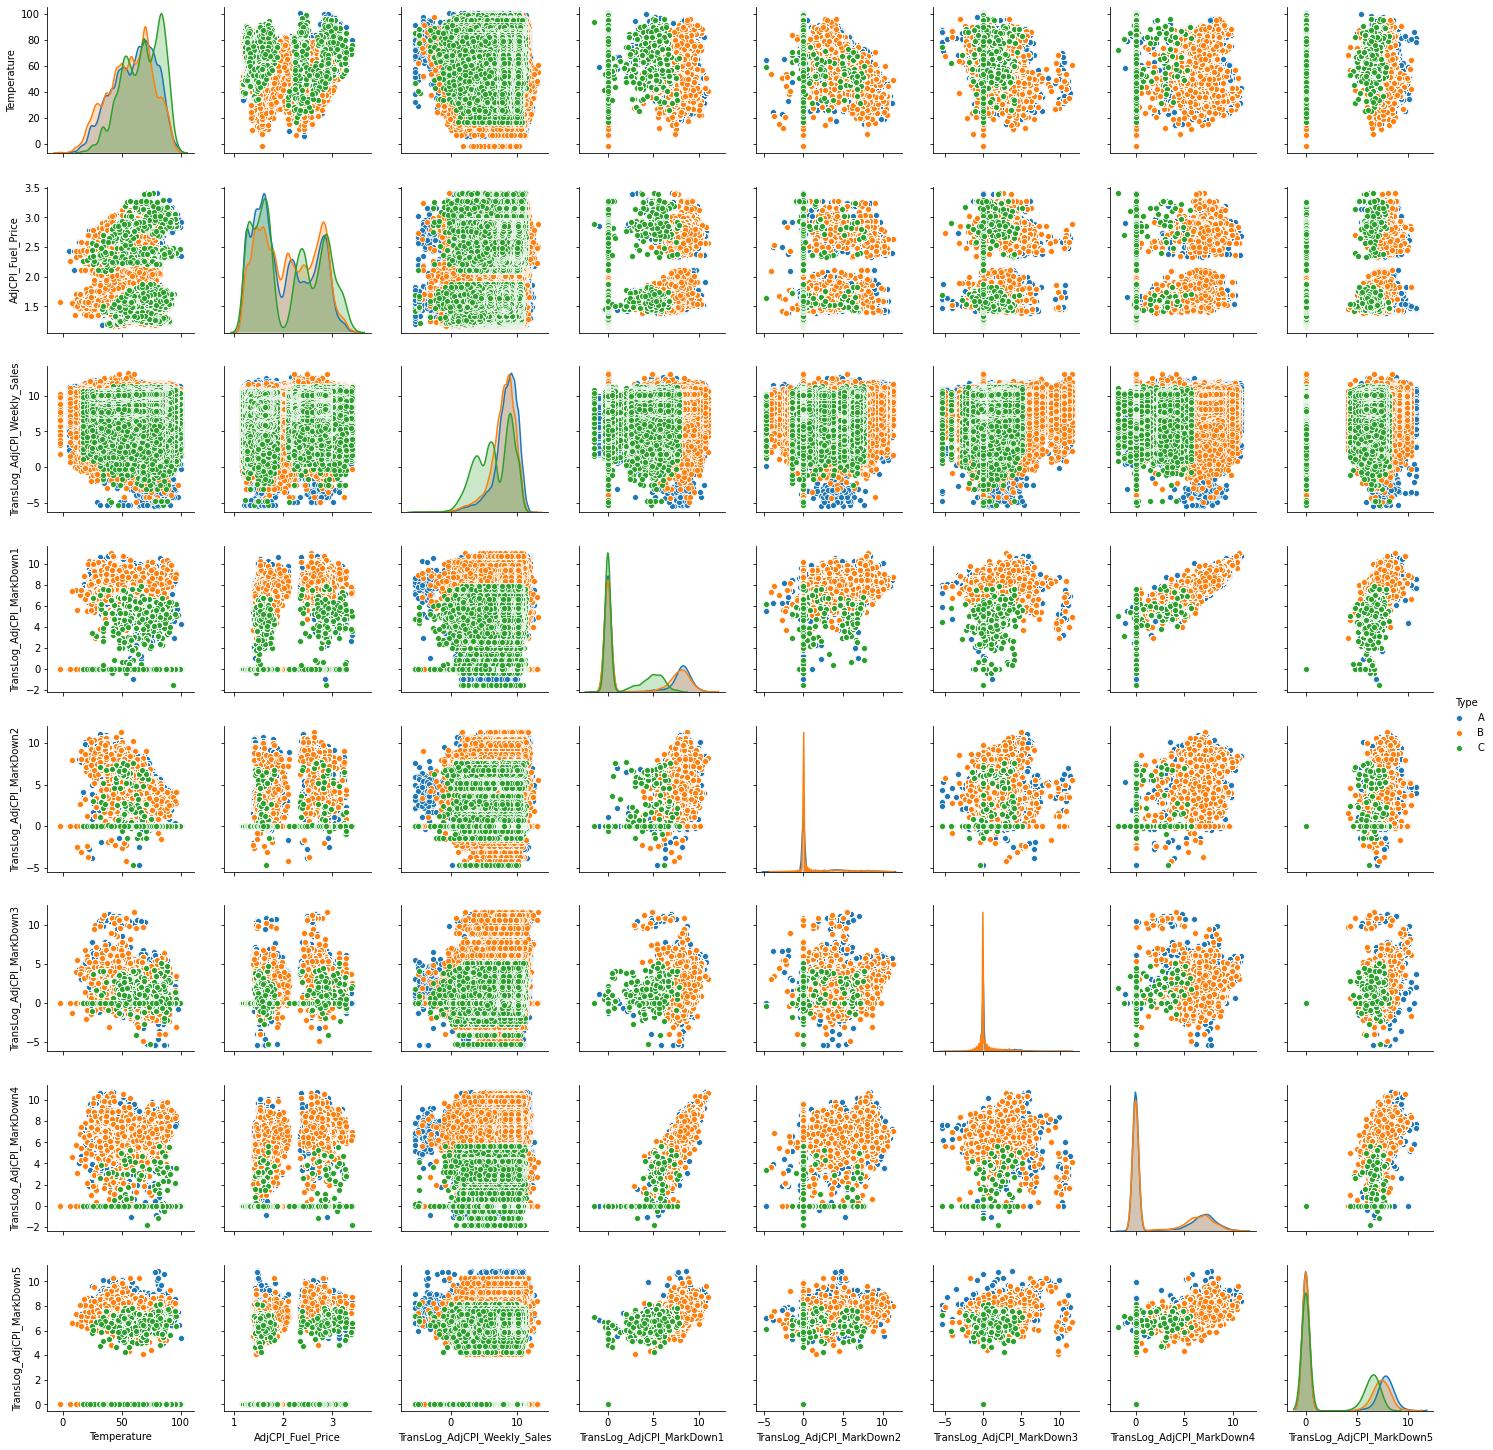

In [135]:
sns.pairplot(df_full.drop(['Store', 'Dept', 'Date', 'IsHoliday', 'Size', 
                           'CPI', 'AdjCPI_Fuel_Price', 'Unemployment'], axis=1), hue='Type')